## Image Classification Part 2

Using: cuda


100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/3
  Train Accuracy: 0.3984
  Val   Accuracy: 0.5442
Epoch 2/3
  Train Accuracy: 0.5934
  Val   Accuracy: 0.5799
Epoch 3/3
  Train Accuracy: 0.6748
  Val   Accuracy: 0.6779


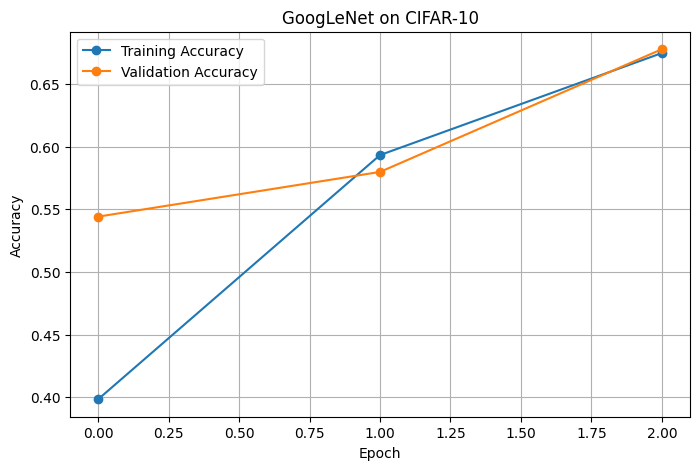

In [1]:
"""
9) Train a GoogLeNet (Inception v1) or its variant using a standard dataset like CIFAR-10.
Plot the training and validation accuracy over epochs and analyze overfitting or underfitting.

->

"""

# Runtime was changed to gpu for running this
# !pip install torch torchvision --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_ld = DataLoader(train_ds, batch_size=32, shuffle=True)
test_ld  = DataLoader(test_ds, batch_size=32, shuffle=False)


model = models.googlenet(weights=None, aux_logits=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_one_epoch():
    model.train()
    correct = 0
    total = 0

    for images, labels in train_ld:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return correct / total

def evaluate():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_ld:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return correct / total


epochs = 3
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    train_acc = train_one_epoch()
    val_acc = evaluate()

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val   Accuracy: {val_acc:.4f}")


plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Training Accuracy", marker="o")
plt.plot(val_acc_list, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GoogLeNet on CIFAR-10")
plt.grid(True)
plt.legend()
plt.show()

10)  You are working in a healthcare AI startup. Your team is tasked with developing a system that automatically classifies medical X-ray images into normal, pneumonia, and COVID-19. Due to limited labeled data, what approach would you suggest using among CNN architectures discussed (e.g., transfer learning with ResNet or Inception variants)? Justify your approach and outline a deployment strategy for production use.

->


Recommendation: approach + justification + production deployment plan
Context: classify chest X-rays into Normal / Pneumonia / COVID-19 with *limited labeled data*.



 1) High-level approach (short)
Use transfer learning with a proven medical-imaging backbone (e.g., DenseNet-121 or ResNet-50) pre-trained on ImageNet, then:

1. Replace the top classifier for 3 classes.  
2. Train in two stages:
   - Stage A (feature extraction): freeze the backbone, train only the new classifier.
   - Stage B (fine-tuning): unfreeze top blocks (last N conv blocks) and fine-tune with a low LR.  
3. Use heavy data augmentation, class-imbalance handling (weighted loss / focal loss / oversampling), cross-validation, and ensembling where possible.

Why: transfer learning is well supported in medical imaging literature and reduces data / compute needs while giving strong baseline performance.



 2) Model choice & justification
- DenseNet-121 (CheXNet-style) or ResNet-50 are good defaults:
  - DenseNet-121 was successfully used for chest X-ray pneumonia detection (CheXNet) and is known to perform well on chest X-ray tasks.
  - ResNet-variants are widely used, robust, and efficient for transfer learning. Reviews show ResNet/DenseNet/VGG/GoogleNet are commonly effective in medical TL.
- Inception/GoogLeNet can work, but DenseNet/ResNet usually give simpler fine-tuning and inference tradeoffs.




 3) Training best practices (to mitigate limited data + safety)
- Data  
  - Curate high-quality labels, consolidate multiple radiologist reads if possible.  
  - Use external public chest X-ray datasets (where permitted) for pre-training / augmentation of domain knowledge.
- Augmentation  
  - Random rotations, translations, horizontal flips (with clinical care: avoid unrealistic transforms), intensity/contrast jitter, small-scale elastic transforms.  
- Class imbalance  
  - Use class weights in CrossEntropy, focal loss, or balanced sampling.
- Cross-validation & holdout  
  - Use stratified k-fold CV and a held-out external test set (from another hospital if possible).
- Uncertainty & calibration  
  - Estimate predictive uncertainty (MC dropout, deep ensembles) and calibrate probabilities (temperature scaling) before deployment.
- Explainability  
  - Produce saliency maps (Grad-CAM) for triage and clinician review — *but be cautious*: saliency methods have limitations and should be validated by experts.
- Evaluation metrics  
  - Report per-class precision/recall, ROC/AUC, confusion matrix, and clinical utility metrics (e.g., NPV for screening).  
- Robustness checks  
  - Test on different demographics, device types, and image acquisition settings; test for confounding (text labels in images, portable vs upright X-ray).



 4) Minimal training recipe (practical)
1. Input size: resize to 224×224 (backbone default).  
2. Stage A: freeze backbone, train classifier for 5–10 epochs, LR ≈ 1e-3.  
3. Stage B: unfreeze top 1–3 blocks, LR ≈ 1e-4, train 10–30 epochs with early stopping.  
4. Use Adam/SGD with momentum, mixed precision (fp16) for faster training.  
5. Use validation AUC to pick checkpoint; save top-k checkpoints and a calibration mapping.



 5) Deployment strategy (production) — end-to-end

A. System architecture
- Model serving: containerize with Docker; serve with TorchServe / TensorFlow Serving / Triton.  
- API layer: REST/gRPC inference endpoint that accepts DICOM/PNG/JPEG and returns: predicted class probs, top-k class, uncertainty score, and saliency map.  
- Preprocessing microservice: handles DICOM -> pixel conversion, windowing, normalization, and input validation.  
- Postprocessing microservice: applies calibration, thresholding, and converts saliency maps to overlay.  
- UI / clinician integration: PACS viewer plugin or web dashboard for radiologists with human-in-the-loop feedback.

B. MLOps / lifecycle
- CI/CD for models: automated tests (unit, data-schema, model smoke tests), model validation pipeline.  
- Monitoring & observability: collect inference latency, throughput, input distribution drift, accuracy on periodic labeled samples, and data-quality metrics. Trigger alerts for drift.  
- Logging & audit: store (anonymized) inputs, predictions, clinician corrections, and timestamps for traceability and post-hoc review.  
- Retraining pipeline: schedule periodic retraining or trigger on drift; validate on external holdouts before rollout.  
- A/B / canary rollout: deploy to a small subset of users first, monitor performance, then rollout.

C. Safety & clinical governance
- Human-in-the-loop: model results should be assistive, not autonomous; clinicians must review and accept final decision.  
- Risk management: define clinical use cases, risk classes, and failure modes.  
- Validation: prospective validation study (multi-site) before clinical deployment.  
- Regulatory: follow local regulator guidance for AI/ML SaMD; FDA has lifecycle recommendations for AI/ML medical devices — incorporate software lifecycle, monitoring, and change control.



 6) Privacy, security & compliance
- Ensure HIPAA/GDPR compliance: de-identify images, encrypt data at rest/in transit, RBAC and audit logs.  
- Secure model & data pipelines against data leakage and model inversion attacks.



 7) Validation & clinical evaluation
- Perform retrospective internal validation → multi-center external validation → prospective clinical validation.  
- Report clinically meaningful endpoints, not just aggregate accuracy (e.g., effect on radiologist workflow, sensitivity for COVID vs pneumonia).



 8) Common pitfalls & mitigations
- Spurious correlations (text tags, portable markers): mitigate via data cleaning and adversarial validation.  
- Overreliance on saliency maps: validate saliency against radiologist annotations and use multiple XAI methods.
- Insufficient external validation: always test on different hospitals/equipment.